# Libraries

In [1]:
! pip install transformers timm albumentations --quiet
! pip install ipywidgets --quiet

In [2]:
# Standard Libraries
import os
import random
from collections import Counter

# Numerical and Data Handling Libraries
import numpy as np
import pandas as pd

# Image Processing Libraries
import cv2
from PIL import Image

# Plotting and Visualization
import matplotlib.pyplot as plt

# PyTorch and Torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Transformers for Vision Models
from transformers import ViTConfig, ViTForImageClassification, ViTImageProcessor

# Utility Libraries
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# jupyter nbextension enable --py widgetsnbextension
from google.colab import output
output.enable_custom_widget_manager()

# Data Import

In [3]:
train_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/train_images"
val_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/val_images"
test_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/test_images/mistery_cat"

# Vision Transformer Model

In [4]:
from transformers import AutoImageProcessor, SwinForImageClassification

# Set the model name to Emiel's fine-tuned Swin model for bird classification
model_name = "Emiel/cub-200-bird-classifier-swin"

# Load the image processor automatically
processor = AutoImageProcessor.from_pretrained(model_name)

# Load the Swin model, specifying the number of classes (200 for CUB-200)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=20,  # Ensure this matches the number of classes in your dataset
    ignore_mismatched_sizes=True
)

preprocessor_config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.95k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/786M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at Emiel/cub-200-bird-classifier-swin and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([200]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([200, 1536]) in the checkpoint and torch.Size([20, 1536]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# import timm
# model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=20)

## Freeze all feature layers of ViT

In [6]:
# Freeze all feature layers of the Swin backbone (train only the classification head)
for param in model.swin.parameters():
    param.requires_grad = False

# Ensure the classification head is trainable
for param in model.classifier.parameters():
    param.requires_grad = True

## Set layer-wise learning rate

In [7]:
from transformers import AdamW

# Set layer-wise learning rate (feature layer learning rate is lower)
optimizer = AdamW(
    [
        {"params": model.swin.parameters(), "lr": 1e-5},  # Feature extraction layer
        {"params": model.classifier.parameters(), "lr": 3e-4}  # Classification header
    ],
    weight_decay=0.01
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
# Verify that the classification layer is randomly initialized (correct state should be True)
print(model.classifier.weight.mean().item())  # Should be close to 0 (normal distribution initialization)
print(model.classifier.bias.mean().item())    # Should be close to 0

8.341448119608685e-05
0.0


In [9]:
submission_class_order = [
    'Groove_billed_Ani',
    'Red_winged_Blackbird',
    'Rusty_Blackbird',
    'Gray_Catbird',
    'Brandt_Cormorant',
    'Eastern_Towhee',
    'Indigo_Bunting',
    'Brewer_Blackbird',
    'Painted_Bunting',
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_headed_Blackbird',
    'American_Crow',
    'Fish_Crow',
    'Brown_Creeper',
    'Yellow_billed_Cuckoo',
    'Yellow_breasted_Chat',
    'Black_billed_Cuckoo',
    'Gray_crowned_Rosy_Finch',
    'Bronzed_Cowbird'
]

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BirdDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.dataset = ImageFolder(root=main_dir, transform=transform)
        self.class_to_idx = self.dataset.class_to_idx
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

# Updated training transform: resize a bit larger then randomly crop to 384
train_transform = transforms.Compose([
    transforms.Resize((400, 400)),   # Resize to a slightly larger size for augmentation
    transforms.RandomCrop(384),      # Random crop to 384x384
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# Updated validation transform: directly resize to 384
val_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

train_dataset = BirdDataset(train_dir, transform=train_transform)
val_dataset = BirdDataset(val_dir, transform=val_transform)

def validate_class_order(train_class_order, submission_order):
    """Make sure the category names and order of both lists are exactly the same"""
    if len(train_class_order) != len(submission_order):
        raise ValueError(f"The number of categories does not match! Training set: {len(train_class_order)}, Submission Requirements: {len(submission_order)}")
    
    for train_cls, sub_cls in zip(train_class_order, submission_order):
        if train_cls != sub_cls:
            raise ValueError(f"Inconsistent order: training set '{train_cls}' vs Submission Requirements '{sub_cls}'")
    return True

train_class_order = sorted(train_dataset.class_to_idx.keys())

try:
    validate_class_order(train_class_order, submission_class_order)
except ValueError as e:
    print("Category order inconsistency detected, automatically correcting...")
    from torchvision.datasets import DatasetFolder
    
    class OrderedImageFolder(DatasetFolder):
        """Forces the data sets of categories to be loaded in a specified order"""
        def __init__(self, root, class_order, transform=None):
            self.class_order = class_order
            super().__init__(
                root,
                loader=lambda x: Image.open(x).convert("RGB"),
                extensions=('jpg', 'jpeg', 'png'),
                transform=transform,
                target_transform=None
            )
            
        def find_classes(self, directory):
            classes = self.class_order 
            class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
            return classes, class_to_idx
    
    train_dataset = OrderedImageFolder(
        train_dir, 
        class_order=submission_class_order,
        transform=train_transform
    )
    val_dataset = OrderedImageFolder(
        val_dir,
        class_order=submission_class_order,
        transform=val_transform
    )
    
    print("Corrected category order：", train_dataset.classes)
    
# Category index validation (ensuring consistency with submission format)
assert sorted(train_dataset.class_to_idx.keys()) == sorted(submission_class_order), "Category order mismatch！"

Category order inconsistency detected, automatically correcting...
Corrected category order： ['Groove_billed_Ani', 'Red_winged_Blackbird', 'Rusty_Blackbird', 'Gray_Catbird', 'Brandt_Cormorant', 'Eastern_Towhee', 'Indigo_Bunting', 'Brewer_Blackbird', 'Painted_Bunting', 'Bobolink', 'Lazuli_Bunting', 'Yellow_headed_Blackbird', 'American_Crow', 'Fish_Crow', 'Brown_Creeper', 'Yellow_billed_Cuckoo', 'Yellow_breasted_Chat', 'Black_billed_Cuckoo', 'Gray_crowned_Rosy_Finch', 'Bronzed_Cowbird']


Epoch 01:
Train Loss: 1.3534 | Acc: 0.6574
Val Loss: 0.2534 | Acc: 0.9195

New best model saved with validation accuracy: 0.9195
Epoch 02:
Train Loss: 0.3004 | Acc: 0.9221
Val Loss: 0.1612 | Acc: 0.9364

New best model saved with validation accuracy: 0.9364
Epoch 03:
Train Loss: 0.2111 | Acc: 0.9370
Val Loss: 0.1356 | Acc: 0.9492

New best model saved with validation accuracy: 0.9492
Epoch 04:
Train Loss: 0.1777 | Acc: 0.9466
Val Loss: 0.1214 | Acc: 0.9449

Epoch 05:
Train Loss: 0.1437 | Acc: 0.9509
Val Loss: 0.1235 | Acc: 0.9364

Epoch 06:
Train Loss: 0.1309 | Acc: 0.9637
Val Loss: 0.1274 | Acc: 0.9322

Epoch 07:
Train Loss: 0.1082 | Acc: 0.9723
Val Loss: 0.1192 | Acc: 0.9407

Epoch 08:
Train Loss: 0.0962 | Acc: 0.9776
Val Loss: 0.1295 | Acc: 0.9492

Epoch 09:
Train Loss: 0.0951 | Acc: 0.9701
Val Loss: 0.1244 | Acc: 0.9449

Epoch 10:
Train Loss: 0.0789 | Acc: 0.9851
Val Loss: 0.1214 | Acc: 0.9449

Epoch 11:
Train Loss: 0.0701 | Acc: 0.9872
Val Loss: 0.1171 | Acc: 0.9492

Epoch 12:
Tra

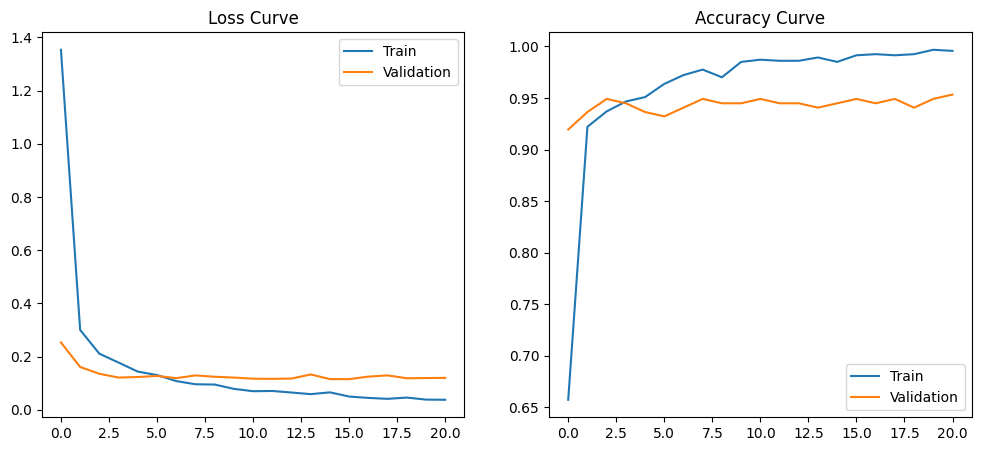

In [11]:
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# (Assuming train_dataset, val_dataset, model, optimizer, criterion, etc. are already defined)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

criterion = torch.nn.CrossEntropyLoss()
model = model.to(device)

class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss = 0
    correct = 0
    
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

def validate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            
            total_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

scaler = torch.amp.GradScaler('cuda')
early_stopper = EarlyStopper(patience=5, min_delta=0.001)
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# Variables to track the best validation accuracy
best_val_acc = 0.0
best_model_path = "/kaggle/working/best_model.pth"

for epoch in range(50):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scaler)
    val_loss, val_acc = validate(model, val_loader)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1:02d}:")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}\n")
    
    # Save model parameters if current validation accuracy is the best so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with validation accuracy: {val_acc:.4f}")
    
    if early_stopper.early_stop(val_loss):
        print("Early stopping triggered!")
        break

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

In [12]:
import os
import torch

# Define a save directory for your Swin model
save_dir = "/kaggle/working/swin_model"
os.makedirs(save_dir, exist_ok=True)

# Save the model state_dict (weights)
torch.save(model.state_dict(), os.path.join(save_dir, "swin_model_weights.pth"))

# Save the processor (e.g., the image preprocessor) in Hugging Face format
processor.save_pretrained(save_dir)

# Save class information for later use
class_info = {
    "class_order": submission_class_order,
    "class_to_idx": train_dataset.class_to_idx,
    "idx_to_class": {v: k for k, v in train_dataset.class_to_idx.items()}
}
torch.save(class_info, os.path.join(save_dir, "class_info.pth"))

# Save training configuration details
train_config = {
    "epochs_trained": len(history['train_loss']),
    "best_val_acc": max(history['val_acc']),
    "optimizer_state": optimizer.state_dict()
}
torch.save(train_config, os.path.join(save_dir, "train_config.pth"))

print(f"Model Saved to: {save_dir}")

# Second save using the Hugging Face format (this saves both the model and processor)
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

# Save class order as a text file (if needed for later reference)
with open(os.path.join(save_dir, "class_info.txt"), "w") as f:
    f.write("\n".join(submission_class_order))

print("HuggingFace Format Saved")

Model Saved to: /kaggle/working/swin_model
HuggingFace Format Saved


# Test and Generate Submission File

In [13]:
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, AutoConfig, SwinForImageClassification

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Submission category order (must match your training/inference ordering)
submission_class_order = [
    'Groove_billed_Ani',
    'Red_winged_Blackbird',
    'Rusty_Blackbird',
    'Gray_Catbird',
    'Brandt_Cormorant',
    'Eastern_Towhee',
    'Indigo_Bunting',
    'Brewer_Blackbird',
    'Painted_Bunting',
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_headed_Blackbird',
    'American_Crow',
    'Fish_Crow',
    'Brown_Creeper',
    'Yellow_billed_Cuckoo',
    'Yellow_breasted_Chat',
    'Black_billed_Cuckoo',
    'Gray_crowned_Rosy_Finch',
    'Bronzed_Cowbird'
]

# Load the image processor from your saved model directory
# (This assumes you saved the processor with your model.)
model_dir = "/kaggle/working/swin_model"  # Update this directory if needed
processor = AutoImageProcessor.from_pretrained(model_dir)

# Set the expected resolution; update this value if your training used a different size.
expected_size = 384

val_transform = transforms.Compose([
    transforms.Resize((expected_size, expected_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# Define a Dataset class for the test images.
class CompetitionTestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.image_files = sorted(os.listdir(test_dir))  # Keep a strict order
        self.image_paths = [os.path.join(test_dir, f) for f in self.image_files]
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Return the image and its filename
        return image, os.path.basename(self.image_paths[idx])

def load_trained_model(model_dir, class_order):
    # Define the expected file names.
    config_path = os.path.join(model_dir, "config.json")
    primary_model_path = os.path.join(model_dir, "pytorch_model.bin")
    alt_model_path = os.path.join(model_dir, "swin_model_weights.pth")
    
    # Check that the config file exists.
    if not os.path.exists(config_path):
        raise FileNotFoundError("Missing Essential File: config.json")
    
    # Determine which model weight file to use.
    if os.path.exists(primary_model_path):
        model_path = primary_model_path
    elif os.path.exists(alt_model_path):
        model_path = alt_model_path
        print("Using alternate model weight file:", alt_model_path)
    else:
        raise FileNotFoundError("Missing Essential File: pytorch_model.bin or swin_model_weights.pth")
    
    # Load configuration from the saved directory.
    config = AutoConfig.from_pretrained(model_dir)
    if config.num_labels != len(class_order):
        raise ValueError(
            f"Model num_labels ({config.num_labels}) does not match the submission requirement ({len(class_order)})"
        )
    
    # Initialize the model from the configuration using the constructor.
    model = SwinForImageClassification(config)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    
    # Optionally, override label mappings if they are inconsistent.
    if config.id2label != {i: cls for i, cls in enumerate(class_order)}:
        print("Warning: The order of categories in the model configuration is inconsistent with the submission requirements. Overriding with submission order.")
        config.id2label = {i: cls for i, cls in enumerate(class_order)}
        config.label2id = {cls: i for i, cls in enumerate(class_order)}
    
    model.eval()
    return model


# Function to generate a submission CSV file.
def generate_submission(test_dir, model_dir, output_csv="submission.csv"):
    test_dataset = CompetitionTestDataset(test_dir, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
    
    model = load_trained_model(model_dir, submission_class_order)
    
    filenames = []
    predictions = []
    
    with torch.no_grad():
        for images, paths in test_loader:
            outputs = model(images.to(device))
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            filenames.extend(paths)
            predictions.extend(batch_preds.tolist())
    
    submission_df = pd.DataFrame({
        'path': filenames,
        'class_idx': predictions
    })
    
    print("\nValidation Results:")
    print(f"Total Samples: {len(submission_df)}")
    print(f"Number of unique file names: {submission_df['path'].nunique()}")
    print(f"Predicted category distribution:\n{submission_df['class_idx'].value_counts().sort_index()}")
    
    submission_df.to_csv(output_csv, index=False)
    print(f"\nSubmission CSV saved to: {output_csv}")

# Main entry point for generating submission.
if __name__ == "__main__":
    # Update test_dir as needed.
    test_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/test_images/mistery_cat"
    generate_submission(test_dir, model_dir)

Using alternate model weight file: /kaggle/working/swin_model/swin_model_weights.pth


<ipython-input-13-c4120aa84d87>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))



Validation Results:
Total Samples: 400
Number of unique file names: 400
Predicted category distribution:
class_idx
0     19
1     17
2     25
3     19
4     22
5     20
6     16
7     21
8     19
9     20
10    20
11    17
12    18
13    23
14    20
15    21
16    20
17    20
18    22
19    21
Name: count, dtype: int64

Submission CSV saved to: submission.csv
